University of Helsinki, Department of Mathematics and Statistics  
MAST32001 Computational Statistics I, Spring 2018  
Antti Honkela  

# Week 2 exercises

## 1. Permutation testing

We will use permutation testing to study if the mother's age (age, below or at least 26) affects the birth weight (bwt) of their babies. We will use the absolute difference in the means as the test statistic. We will focus the analysis on full term pregnancies (gestation >= 273).

Note: when reporting a $p$-value for $b$ more extreme tests out of $m$, use $p = (b+1)/(m+1)$ to avoid zero p-values. 50000 permutations will be sufficient for obtaining the required accuracy.

1. Load the data set below. Test whether the birth weights (bwt) of babies with young (age < 26) and older (age >= 26) mothers are statistically significantly different using the difference of the means as the test statistic. Report the $p$-value you obtain in Moodle.
2. Stratify the analysis by the variable smoking status of the mothers by splitting to separate smoker and non-smoker groups. Constrain the permutations so that only changes within each group are allowed. After the permutation merge the two groups back together to compute the means. Report the $p$-value you obtain in Moodle.

In [36]:
import pandas as pd
import numpy as np
import numpy.random as npr
import scipy.stats as sst

npr.seed(1345)
# Load the data set
babies_full = pd.read_csv("http://www.helsinki.fi/~ahonkela/teaching/compstats1/babies.txt", sep='\t')

# Pick a subset
babies1 = babies_full.iloc[(babies_full['gestation']>=273).values]
babiesYoung = babies1.query('age<26')
babiesOld = babies1.query('age>=26')

smoker = babies1.query('smoke>0')
nonSmoker = babies1.query('smoke<1')

#print(babies1.head(10))

X1 = babiesYoung['bwt'].mean()
X2 = babiesOld['bwt'].mean()

s1 = np.var(babiesYoung['bwt'])
s2 = np.var(babiesOld['bwt'])
N1 = len(babiesYoung.index)
N2 = len(babiesOld.index)

truediff = np.abs(X1-X2)

def sTest(X1,X2,s1,s2,N1,N2):
    return (X1-X2)/np.sqrt((s1/N1)+(s2/N2))

tX, pX = sst.ttest_ind(babiesYoung['bwt'], babiesOld['bwt'], equal_var=False)


tXf = sTest(X1,X2,s1,s2,N1,N2)
print('P-value ', pX)
print('T-value ', tX)
print('bm', tXf )
print('t oma ', tXf)
print('true abs ', truediff)
df = N1+N2 -2
pXf = sst.t.cdf(tXf,df=df)
t_val = sst.t.ppf([pXf], df)
print('t_val_check ', t_val)
print('pXf ', pXf)


fram = babies_full.iloc[(babies_full['gestation']>=273).values]

Ismoker = (fram['smoke'] == 1).values
Inonsmoker = (fram['smoke'] == 0).values
highAge = (fram['age'] >= 26).values
lowAge = (fram['age'] < 26).values

nonsmokermean = np.mean(fram['bwt'].values[Inonsmoker])
smokermean = np.mean(fram['bwt'].values[Ismoker])
lowagemean = np.mean(fram['bwt'].values[lowAge])
highagemean = np.mean(fram['bwt'].values[highAge])
print(nonsmokermean, smokermean)

IhighAge = np.where(highAge)[0]
IlowAge = np.where(lowAge)[0]
IIsmoke = np.where(Ismoker)[0]
IInonsmoke = np.where(Inonsmoker)[0]

numrepeats = 50000
mean_differences = np.zeros(numrepeats)
npr.seed(34234234)
print(Ismoker.shape, highAge.shape)
numhighAgesmokers = np.sum(Ismoker & highAge)
print(numhighAgesmokers)
numlowAgesmokers = np.sum(Ismoker & lowAge)

for i in range(numrepeats):
    I1 = npr.permutation(IhighAge)
    I2 = npr.permutation(IlowAge)
    permmean1 = np.mean(np.concatenate((fram['bwt'].values[I1[0:numhighAgesmokers]],
                                        fram['bwt'].values[I2[0:numlowAgesmokers]])))
    permmean2 = np.mean(np.concatenate((fram['bwt'].values[I1[numhighAgesmokers:]],
                                        fram['bwt'].values[I2[numlowAgesmokers:]])))
    #print(permmean2, permmean1)
    mean_differences[i] = np.abs(permmean1 - permmean2)

print((np.sum(np.abs(lowagemean - highagemean) <= mean_differences) + 1)/(len(mean_differences)+1))

P-value  0.052685000646563666
T-value  -1.9401381701198819
bm -1.9423661130819316
t oma  -1.9423661130819316
true abs  2.1363971993694832
t_val_check  [-1.94236611]
pXf  0.026206489250117225
126.25 118.87267080745342
(878,) (878,)
165
0.0630787384252315


## 2. Bootstrap confidence intervals on data statistics

In this exercise we use bootstrap to estimate confidence intervals for various quantities. (Using 1000 bootstrap samples will give you enough accuracy assuming everything is correctly done.)

1. Use bootstrap to estimate the central 95% confidence interval for the mean of 'bwt' in the full data set loaded in Problem 1. Report the width of the interval in Moodle.
2. Use bootstrap to estimate the central 95% confidence interval for the mean of 'bwt' in the smaller subset of the data set used in Problem 1. Report the width of the interval in Moodle.
3. Use bootstrap to estimate the central 95% confidence interval for the correlation coefficient of 'gestation' and 'age' in the full data set loaded in Problem 1. What does this tell about the relation between the duration of the pregnancy and the age of the mother? Report the bounds of the interval in Moodle.
4. Use bootstrap to estimate the central 95% confidence interval for the correlation coefficient of 'gestation' and 'age' in the smaller subset used in Problem 1. What does this tell about the relation between the duration of the pregnancy and the age of the mother? Report the bounds of the interval in Moodle.

Hint: remember that the size of the bootstrap sample is always the same as the size of the original data set.

In [4]:
import numpy as np
import numpy.random as npr
import pandas as pd
import scipy.stats as sst

npr.seed(1345)
# Load the data set
babies_full = pd.read_csv("http://www.helsinki.fi/~ahonkela/teaching/compstats1/babies.txt", sep='\t')

bwt = babies_full['bwt']

N = 1000
N_bwt = len(bwt)

def bootstrapMeans(data, n):
    bootstrap_means = np.array([np.mean(npr.choice(data, replace=True, size=n)) for i in range(N)])
    print('bootstrap interval:', np.percentile(bootstrap_means, [2.5, 97.5]))
    ival1, ival2 = np.percentile(bootstrap_means, [2.5, 97.5])
    ival_width = abs(ival1-ival2)
    print('interval width: ', ival_width)

bootstrapMeans(bwt, N_bwt)

bootstrap_means = np.array([np.mean(npr.choice(bwt, replace=True, size=N_bwt)) for i in range(N)])
print('1. bootstrap interval:', np.percentile(bootstrap_means, [2.5, 97.5]))
ival1, ival2 = np.percentile(bootstrap_means, [2.5, 97.5])
ival_width = abs(ival1-ival2)
print('interval width: ', ival_width)

babies1 = babies_full.iloc[(babies_full['gestation']>=273).values]
bwt1 = babies1['bwt']
N_bwt1 = len(bwt1)

bootstrapMeans(bwt1, N_bwt1)

bootstrap_means1 = np.array([np.mean(npr.choice(bwt1, replace=True, size=N_bwt1)) for i in range(N)])
print('2. bootstrap interval:', np.percentile(bootstrap_means1, [2.5, 97.5]))
ival1, ival2 = np.percentile(bootstrap_means1, [2.5, 97.5])
ival_width = abs(ival1-ival2)
print('interval width: ', ival_width)

gestation = babies_full['gestation']
age = babies_full['age']
N_gestation = len(gestation)
correlation_interval = np.zeros(N)
for i in range(N):
    indices = npr.choice(range(N_gestation), replace=True, size=N_gestation)
    correlation_interval[i] = np.corrcoef(gestation.values[indices], age.values[indices])[0,1]

print('3. bootstrap interval:', np.percentile(correlation_interval, [2.5, 97.5]))
ival1, ival2 = np.percentile(correlation_interval, [2.5, 97.5])
ival_width = abs(ival1-ival2)
print('interval width: ', ival_width)

gestation = babies1['gestation']
age = babies1['age']
N_gestation = len(gestation)
correlation_interval = np.zeros(N)
for i in range(N):
    indices = npr.choice(range(N_gestation), replace=True, size=N_gestation)
    correlation_interval[i] = np.corrcoef(gestation.values[indices], age.values[indices])[0,1]

print('4. bootstrap interval:', np.percentile(correlation_interval, [2.5, 97.5]))
ival1, ival2 = np.percentile(correlation_interval, [2.5, 97.5])
ival_width = abs(ival1-ival2)
print('interval width: ', ival_width)

bootstrap interval: [118.57123838 120.62554945]
interval width:  2.0543110735418537
1. bootstrap interval: [118.5433432 120.6239011]
interval width:  2.0805579036348263
bootstrap interval: [122.57958428 124.67104214]
interval width:  2.091457858769914
2. bootstrap interval: [122.59083144 124.63442483]
interval width:  2.0435933940774618
3. bootstrap interval: [-0.10796613  0.00499416]
interval width:  0.11296029758576719
4. bootstrap interval: [-0.09303774  0.03640723]
interval width:  0.12944496924853782


## 3. Bootstrap confidence intervals on parameter estimates

In this task, we will use bootstrap to obtain confidence intervals on maximum likelihood parameter estimates for linear regression models. We will apply simple case resampling, i.e. resampling the individuals and then fitting the model using the data $(x_i, y_i)$ from these individuals. There are alternative methods that may work better when the data are limited, but in our case there are enough observations so that this will not be a problem. 1000 bootstrap samples will again give you enough accuracy.

Linear regression fit to scalar $x_i, y_i$ involves fitting the model
$$ y_i = \alpha + \beta x_i + \epsilon_i, $$
where $\beta$ is the regression coefficient and $\alpha$ is the intercept. Assuming $\epsilon_i \sim N(0, \sigma^2)$, the log-likelihood of the model is
$$ \log p(Y | X, \alpha, \beta) = \sum_{i=1}^n \log p(y_i | x_i, \alpha, \beta)
  = \sum_{i=1}^n - \frac{1}{2 \sigma^2} (y_i - \alpha - \beta x_i)^2 + C, $$
where $C$ is independent of $\alpha, \beta$. This is maximised when
$$ \hat{\beta}= \frac{\sum_{i = 1}^n (x - \bar{x})(y - \bar{y}) }{ \sum_{i = 1}^n (x - \bar{x})^2} \\
   \hat{\alpha} = \bar{y} - \hat{\beta} \bar{x},$$
where $\bar{x} = \frac{1}{n} \sum_{i = 1}^n x$ and $\bar{y} = \frac{1}{n} \sum_{i = 1}^n y$.

1. Implement the above linear regression model to predict 'gestation' ($y$) as a function of 'age' ($x$) in the full data set. Report the estimated $\beta$ in Moodle.
2. Use bootstrap to estimate the confidence interval of the regression coefficient $\beta$ in the above model by resampling the individuals used to fit the model. Report the lower and upper bounds of the central 95% confidence interval of $\beta$ in Moodle.


bhat  -0.14028027676816446
ahat  282.94959729544775
yhat  [279.16202982 278.32034816 279.02174955 ... 278.74118899 280.00371148
 277.61894678]


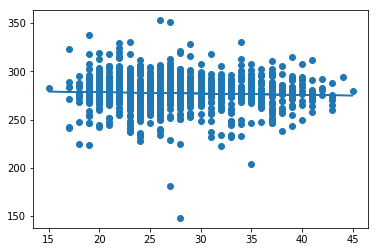

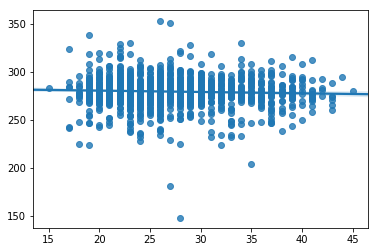

4. bootstrap interval: [-0.2997      0.00409892]
interval width:  0.30379891490082056


In [47]:
#%%
import numpy as np
import numpy.random as npr
import pandas as pd
import scipy.stats as sst
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

npr.seed(100)
# Load the data set
babies_full = pd.read_csv("http://www.helsinki.fi/~ahonkela/teaching/compstats1/babies.txt", sep='\t')

N=1000

y = babies_full['gestation'].values
x = babies_full['age'].values

xmean = np.mean(x)
ymean = np.mean(y)
#sns.regplot(x,y)

#print(sm.OLS(y,x).fit().summary())

var = 1
def epsilon():
    return npr.normal(0,var)


def loglh(x,y,n,a,b,C,var):
    res = 0
    for i in range(n):
        res = res + (-(1/2*var)*(y[i]-a-b*x[i])**2 + C)
    return res

def a_hat(ymean, xmean, bhat):
    return ymean - bhat*xmean

def b_hat(x,y,xmean,ymean):
    first = 0
    second = 0
    for i in range(len(x)):
        first = first + (x[i]-xmean)*(y[i]-ymean)
        second = second + (x[i]-xmean)**2

    return first/second

def b_hat_perm(x,y):
    xmean = x.mean()
    ymean = y.mean()
    first = 0
    second = 0
    for i in range(len(x)):
        first = first + (x[i]-xmean)*(y[i]-ymean)
        second = second + (x[i]-xmean)**2

    return first/second


def y_hat(x,y):
    bh = b_hat(x,y,x.mean(),y.mean())
    ah = a_hat(y.mean(), x.mean(), bh)
    return(ah+bh*x)

bhat = b_hat(x,y,xmean,ymean)
print('bhat ', bhat)
ahat = a_hat(ymean,xmean, bhat)
print('ahat ', ahat)
yhat = y_hat(x,y)
print('yhat ', yhat)
plt.scatter(x,y)
plt.plot(x,ahat+bhat*x +epsilon())
plt.show()
sns.regplot(x,y)
plt.show()


N_yhat = len(yhat)
correlation_interval = np.zeros(N)
for i in range(N):
    indices = npr.choice(range(N_yhat), replace=True, size=N_yhat)
    correlation_interval[i] = b_hat_perm(x[indices], y[indices])

print('4. bootstrap interval:', np.percentile(correlation_interval, [2.5, 97.5]))
ival1, ival2 = np.percentile(correlation_interval, [2.5, 97.5])
ival_width = abs(ival1-ival2)
print('interval width: ', ival_width)

## 4. Density estimation

1. Estimate the joint density of 'bwt' and 'age' in the full data set using kernel density estimation with a 2-dimensional Gaussian kernel
$$ K_h(x) = \frac{1}{2\pi h^2} \exp\left( - \frac{x_1^2 + x_2^2}{2 h^2} \right) $$
with $h=5$. Plot a 2D histogram of the data (`matplotlib.pyplot.hist2d`) and a contour plot of the estimated density. Report the value of the estimated density at point bwt=120, age=25 in Moodle.
2. Use leave-one-out cross validation to find an optimal $h$ in the range `np.linspace(1.0, 10.0, 30)`. Report the value of $h$ and the value of the estimated density at bwt=120, age=25 in Moodle.

(1183, 2)
estimated density at h=5:  0.001208815592410472
h5 koko (122, 31)
Optimal h: 2.2413793103448274
kdens koko (122, 31)
estimated density at optimal h:  0.0015079615119289191
121


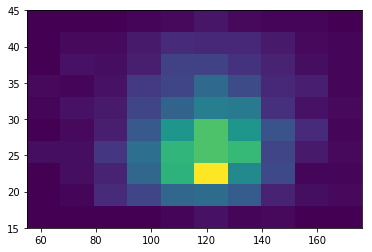

countour plot, h=5


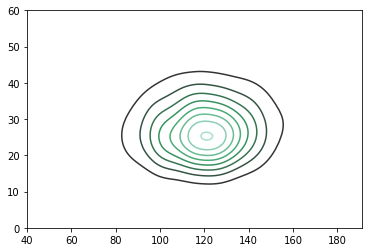

contour plot, h optimal


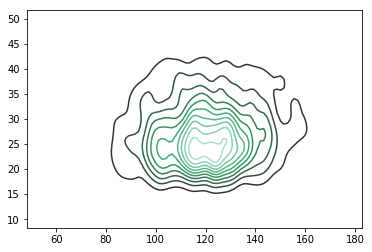

In [74]:
#%%
import numpy as np
import numpy.random as npr
import pandas as pd
import scipy.stats as sst
import matplotlib.pyplot as plt
import seaborn as sns


npr.seed(42)
# Load the data set
babies_full = pd.read_csv("http://www.helsinki.fi/~ahonkela/teaching/compstats1/babies.txt", sep='\t')
bwt = babies_full['bwt'].values
age = babies_full['age'].values
y = bwt
x = age

X=np.column_stack((y,x))
print(X.shape)
#X = X[range(100)][:]
# print(X.shape)

def kh_m(x1,x2):
    first = (2*np.pi)**(-1)
    norm = x1**2 + x2**2
    second = np.exp((-(norm))/2)
    return first*second

def kernel_density(xgrid,ygrid, x, y,h):
    z = np.zeros((len(ygrid), len(xgrid)))

    for i in range(len(ygrid)):
        for j in range(len(xgrid)):
            z[i][j] = np.mean(kh_m(((ygrid[i] - y)/ h),((xgrid[j] - x)/ h))) / h**2
    return z

tx = np.linspace(x.min(),x.max(), x.max()-x.min()+1)
ty = np.linspace(y.min(),y.max(), y.max()-y.min()+1)
kdens = kernel_density(tx,ty,x,y,5)
print('estimated density at h=5: ', kdens[120-y.min()+1][25-x.min()+1])
print('h5 koko', kdens.shape)

def CVLOO(X):
    hsk = np.linspace(1.0,10.0,30)
    logloss = np.zeros(len(hsk))
    kf2 = KFold(n_splits=len(X))
    iii=0
    for train, test in kf2.split(X):
        test_data4 = X[test]
        train_data4 = X[train]
        for i in range(len(hsk)):
            logloss[i] += np.sum(np.log(kernel_density(test_data4[:,1],test_data4[:,0],train_data4[:,1],train_data4[:,0], hsk[i])))
        #print(iii, hsk[np.argmax(logloss)])
        #iii = iii+1
    return (hsk, logloss)

hs, logls = CVLOO(X)
h_opt = hs[np.argmax(logls)]

print("Optimal h:", h_opt)


kdens2 = kernel_density(tx,ty,x,y,h_opt)
print('kdens koko', kdens2.shape)
print('estimated density at optimal h: ', kdens2[120-y.min()][25-x.min()])
print(y.max()-y.min())
plt.hist2d(bwt,age)
plt.show()
print('countour plot, h=5')
sns.kdeplot(bwt, age, kernel='gau', bw=5)
plt.show()
print('contour plot, h optimal')
sns.kdeplot(bwt, age, kernel='gau', bw=h_opt)
plt.show()

## 5. Cross validation for variable selection in linear regression

Cross validation can be used for evaluating the out-of-sample predictive accuracy of models and feature selection. In this task we will study a subset of the birth weight data for old mothers ($\text{age} \ge 30$) and aim to predict the birth weight ('bwt', $y$) as a function of the duration of the pregnancy ('gestation', $x$). We will then evaluate the root mean squared error (RMSE)
$$ RMSE(\epsilon) = \sqrt{\frac{1}{n} \sum_{i=1}^n \epsilon_i^2} $$
of the model.

1. Use all data to fit the linear regression model and evaluate the RMSE of all the predictions. Report the value you obtain in Moodle.
2. Use $k$-fold cross-validation with $k=20$ and estimate the RMSE of the test set predictions. Report the value you obtain in Moodle.
3. Fit a multivariate linear regression model using 'age', 'gestation' and 'weight' as predictors. Report the value of the regression coefficient of 'weight' in Moodle.
4. Evaluate the RMSE of the multivariate fit using LOO CV. Report the value you obtain in Moodle.

Hint: Subtasks 1 and 2 use the linear regression model also used in Problem 3 while subtasks 3 and 4 use a multivariate version of linear regression. To form the multivariate linear regression model, let us consider the data as a matrix $\mathbf{X}$ where each row is an observation and each column is a variable, and $\mathbf{y}$ as a column vector of responses. We can incorporate the intercept $\alpha$ in the same parameter vector $\boldsymbol{\beta}$ by
$$ \mathbf{y} = \mathbf{X} \boldsymbol{\beta} + \alpha \mathbf{1} = \begin{pmatrix} \mathbf{X} & \mathbf{1} \end{pmatrix}
\begin{pmatrix} \boldsymbol{\beta} \\ \alpha \end{pmatrix} = \mathbf{X'} \boldsymbol{\beta'}, $$
i.e. by adding a column of all ones to the data matrix $\mathbf{X}$. In what follows, we will use $\mathbf{X}$ to denote the augmented data matrix and $\boldsymbol{\beta}$ to denote the corresponding augmented vector of regression coefficients.

The maximum likelihood estimate of $\boldsymbol{\beta}$ for the multivariate model can be derived in a similar manner as in Problem 3. The result is
$$ \hat{\boldsymbol{\beta}} = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}. $$

bhat  0.6438502212200982
ahat  -59.084147623152205
RMSE  18.003758812817367
scipy mse  18.003758812817367


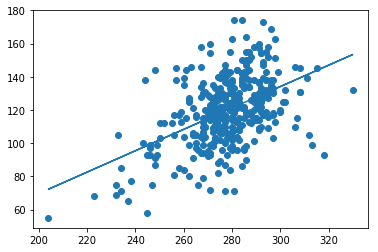

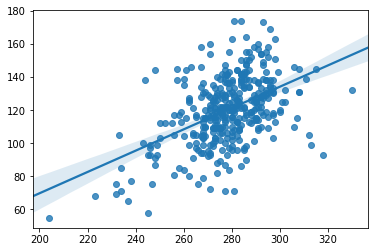

kFold RMSE  18.146790521390198
(371,)
(371, 5)
(371, 3)


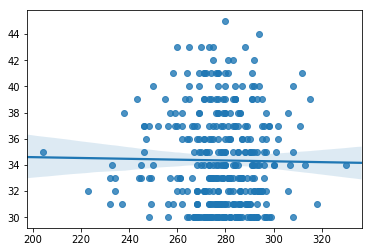

bhat  [ 6.46726278e-01 -1.95761417e-03  1.65222296e-01 -8.17692758e+01]


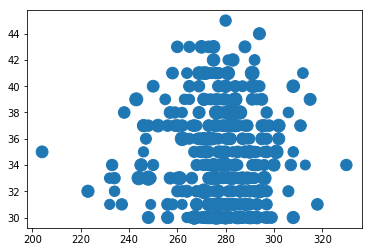

LOO RMSE  108.31678282725613


In [76]:
import numpy as np
import numpy.random as npr
import pandas as pd
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from mpl_toolkits.mplot3d import Axes3D

# Load the data set
babies_full = pd.read_csv("http://www.helsinki.fi/~ahonkela/teaching/compstats1/babies.txt", sep='\t')

# Pick a subset
babies5 = babies_full.loc[(babies_full['age']>=30).values,:]
#print(babies5.head(10))
y = babies5['bwt'].values
x = babies5['gestation'].values

ymean = np.mean(y)
xmean = np.mean(x)

var = 1
def epsilon():
    return npr.normal(0,var)

def RMSE(pred, target):
    return np.sqrt(np.mean((target-pred)**2))

def a_hat(ymean, xmean, bhat):
    return ymean - bhat*xmean

def b_hat(x,y,xmean,ymean):
    first = 0
    second = 0
    for i in range(len(x)):
        first = first + (x[i]-xmean)*(y[i]-ymean)
        second = second + (x[i]-xmean)**2

    return first/second

def predict(x,y):
    ymean = np.mean(y)
    xmean = np.mean(x)
    bhat = b_hat(x,y,xmean,ymean)
    ahat = a_hat(ymean,xmean, bhat)
    return ahat+bhat*x +epsilon()

def predict_coefs(x,y):
    ymean = np.mean(y)
    xmean = np.mean(x)
    bhat = b_hat(x,y,xmean,ymean)
    ahat = a_hat(ymean,xmean, bhat)
    return ahat, bhat

def calc_y(x, a_hat, b_hat):
    return ahat+bhat*x +epsilon()


bhat = b_hat(x,y,xmean,ymean)
ahat = a_hat(ymean,xmean, bhat)
print('bhat ', bhat)
print('ahat ', ahat)

prediction = ahat+bhat*x
err = RMSE(prediction, y)
print('RMSE ', err)

rms = np.sqrt(mean_squared_error(y, prediction))
print('scipy mse ', rms)

#check that linreg is valid
plt.scatter(x,y)
plt.plot(x,prediction)
plt.show()
sns.regplot(x,y)
plt.show()


k=20
sum=0
arr = np.transpose(np.asarray([x,y]))

kf = KFold(n_splits=k)
for train, test in kf.split(arr):
    test_data = arr[test]
    train_data = arr[train]
    ahat, bhat = predict_coefs(train_data[:,0], train_data[:,1])
    pr = calc_y(test_data[:,0], ahat, bhat)
    sum = sum + (RMSE(pr, test_data[:,1]))**2
avg_MSE = np.sqrt(sum/k)
print('kFold RMSE ', avg_MSE)




###  MULTIVARIATE  ###
gest = babies5['gestation'].values
age = babies5['age'].values
weight = babies5['weight'].values
bwt = babies5['bwt'].values

print(bwt.shape)
X = np.column_stack((gest,age,weight))
X1 = np.append(X, np.ones((len(X),1)), axis =1)
X2 = np.column_stack((X1,bwt))

print(X2.shape)
print(X2[:,range(3)].shape)
sns.regplot(gest,age,weight)
plt.show()

def b_hat4(X,y):
    Xt = np.transpose(X)
    first = np.matmul(Xt,X)
    # invXtX = np.linalg.inv(np.linalg.cholesky(first))
    # invXtX = np.dot(np.transpose(invXtX),invXtX)
    invXtX = np.linalg.inv(first)
    multX = np.matmul(invXtX, Xt)
    return np.matmul(multX,y)

def multiy(X, bhat):
    return np.matmul(X, bhat)

bhat4 = b_hat4(X1, bwt)

print('bhat ', bhat4)

yyy = multiy(X1, bhat4)

plt.scatter(gest, age, weight)
#plt.plot(X,yyy)
plt.show()

errors = np.zeros(len(X2))
iii = 0
kf2 = KFold(n_splits=len(X2))
for train, test in kf2.split(X2):
    test_data4 = X2[test]
    test_data4 = test_data4[:,range(4)]
    train_data4 = X2[train]
    train_data4 = train_data4[:,range(4)]
    
    test_Y = X2[test]
    test_Y = test_Y[:,4]
    train_Y = X2[train]
    train_Y = train_Y[:,4]
    
    bhat4 = b_hat4(train_data4,train_Y)
    yhat4 = multiy(test_data4,bhat4)
    errors[iii] += RMSE(yhat4, test_Y)
    iii += 1
#avg_MSE4 = np.sqrt(sum4/len(X2)**2)
loomse = RMSE(errors, bwt)
print('LOO RMSE ', loomse)